In [5]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt


sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [6]:
ENERGY_TRACE = "../pkg/model/bupt_energy.csv"

In [7]:
clean_df = pd.read_csv(ENERGY_TRACE)

mean_J_per_second = (clean_df['solar_harvested_energy_w'].sum() - clean_df['total_energy_w'].sum()) / len(clean_df)

mean_J_solar_per_second = clean_df['solar_harvested_energy_w'].sum() / len(clean_df)
mean_J_total_per_second = clean_df['total_energy_w'].sum() / len(clean_df)

print(f"Mean energy per second: {mean_J_per_second:.2f} J/s")
print(f"Mean solar energy per second: {mean_J_solar_per_second:.2f} J/s")
print(f"Mean total energy per second: {mean_J_total_per_second:.2f} J/s")

min_J_total_per_second = clean_df['total_energy_w'].min()
max_J_total_per_second = clean_df['total_energy_w'].max()

print(f"Min total energy per second: {min_J_total_per_second:.2f} J/s")
print(f"Max total energy per second: {max_J_total_per_second:.2f} J/s")

min_J_solar_per_second = clean_df['solar_harvested_energy_w'].min()
max_J_solar_per_second = clean_df['solar_harvested_energy_w'].max()

print(f"Min solar energy per second: {min_J_solar_per_second:.2f} J/s")
print(f"Max solar energy per second: {max_J_solar_per_second:.2f} J/s")

Mean energy per second: 3.08 J/s
Mean solar energy per second: 16.60 J/s
Mean total energy per second: 13.52 J/s
Min total energy per second: 6.95 J/s
Max total energy per second: 27.14 J/s
Min solar energy per second: 0.00 J/s
Max solar energy per second: 48.59 J/s


[(0.0, 57500.0)]

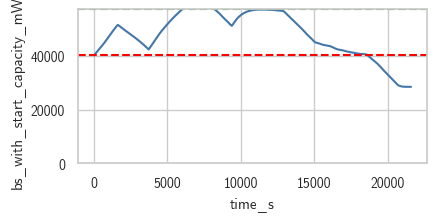

In [8]:
max_capacity_mWh = 57.5 * 1000
dod_limit = 0.7 * max_capacity_mWh
start_capacity = 0.7 * max_capacity_mWh
assumed_drain = 5.0

clean_df["battery_drain_Ws"] = clean_df.apply(lambda x: x["solar_harvested_energy_w"] - assumed_drain - x["total_energy_w"], axis=1)
# for each item, it is the sum of the previous items
clean_df["battery_state_Ws"] = clean_df["battery_drain_Ws"].cumsum()
clean_df["battery_state_mWh"] = clean_df["battery_state_Ws"] / 3600 * 1000
clean_df.head()

clean_df["bs_with_start_capacity_mWH"] = clean_df["battery_state_mWh"] + start_capacity
g = sns.lineplot(data=clean_df, x='time_s', y='bs_with_start_capacity_mWH', estimator=None)

g.axhline(dod_limit, color='red', linestyle='--')
g.axhline(max_capacity_mWh, color='green', linestyle='--')
g.set(ylim=(0, max_capacity_mWh))

webf NOT subset; don't know how to subset; dropped


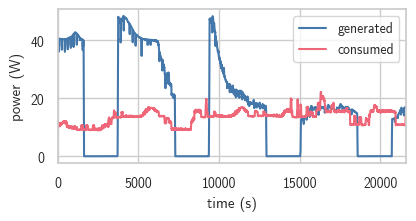

In [9]:
# rolling average
df_rolling = clean_df.copy()
df_rolling["time_dt"] = pd.to_datetime(df_rolling["time_s"], unit='s')

smoothing = "20s"
df_rolling = df_rolling.set_index("time_dt").rolling(smoothing).mean()
df_rolling["time_s"] = df_rolling.index
df_rolling["time_s"] = df_rolling["time_s"].astype(int) / 1e9

g = sns.lineplot(data=df_rolling, x='time_s', y='solar_harvested_energy_w', estimator=None, color=pal[0])
sns.lineplot(data=df_rolling, x='time_s', y='total_energy_w', estimator=None, ax=g, color=pal[1])

g.set(xlabel='time (s)', ylabel='power (W)')
g.legend(['generated', 'consumed'])
g.set(xlim=(0, 21600))
plt.savefig("energy-trace.pdf", bbox_inches='tight')

In [10]:
path = "../satellite/telemetry_all.csv"
df_full = pd.read_csv(path)

df_full["TIME"] = pd.to_datetime(df_full["Time"]).apply(lambda x: int(pd.Timestamp.timestamp(x)))

df_full = df_full.reset_index(drop=True)

In [11]:
df = df_full.dropna()
df=df[(1683244800<=df['TIME'])&(df['TIME']<=1683244800+60*60*48)]
df["solar_harvested_energy_w"] = (
    df["MPPT1_Iout"] / 1000 * df["Total_U"] / 1000
    + df["MPPT2_Iout"] / 1000 * df["Total_U"] / 1000
) * 1.1
df["payload_energy_w"] = (
    df["I_Atlas200DK-A"] * 12.1 + df["I_Atlas200DK-B"] * 12.1 + df["I_Pi-A"] * 5.1
) / 1000
df["comms_energy_w"] = (
    df["POBC_I_5V"] / 1000 * 5
    + df["XMIT_A_12V"] / 1000 * 12
    + df["XMIT_B_12V"] / 1000 * 12
    + df["UV_I"] / 1000 * 3.3
)

df["total_energy_w"] = (
    (df["Total_I"] / 1000 * df["Total_U"] / 1000) * 0.9
    - df["comms_energy_w"]
    - df["payload_energy_w"]
)

df["TIME"] = (df["TIME"] - df["TIME"].iloc[0]) / 60

df = df[["TIME", "solar_harvested_energy_w", "total_energy_w"]]

df["time_s"] = (df["TIME"] * 60).astype(int)
df = df[["time_s", "solar_harvested_energy_w", "total_energy_w"]]

save_df_new = pd.DataFrame({"time_s": range(df["time_s"].max() + 1)})
save_df = save_df_new.merge(df, on="time_s", how="left")
save_df.fillna(method="ffill", inplace=True)

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_72221/226296579.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  save_df.fillna(method="ffill", inplace=True)


In [12]:
mean_J_per_second = (save_df['solar_harvested_energy_w'].sum() - save_df['total_energy_w'].sum()) / len(save_df)

mean_J_solar_per_second = save_df['solar_harvested_energy_w'].sum() / len(save_df)
mean_J_total_per_second = save_df['total_energy_w'].sum() / len(save_df)

print(f"Mean energy per second: {mean_J_per_second:.2f} J/s")
print(f"Mean solar energy per second: {mean_J_solar_per_second:.2f} J/s")
print(f"Mean total energy per second: {mean_J_total_per_second:.2f} J/s")

Mean energy per second: 2.95 J/s
Mean solar energy per second: 15.59 J/s
Mean total energy per second: 12.64 J/s
